In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

%matplotlib inline

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [4]:
def true_f(x, e=0):
    return x + 0.3 * np.sin(2 * np.pi * (x + e)) + 0.3 * np.sin(4. * np.pi * (x + e))
    #return np.sin(12.0 * x) + 0.66 * np.cos(25.0 * x) + 3.0
    #return np.sin(x)


def get_data(train_size=100, test_size=100):
    n = train_size + test_size

    np.random.seed(42)

    #X = np.linspace(-2.0, 2.0, num=n)
    X = np.random.uniform(-1.0, 1.0, n)
    e = np.random.normal(0, 0.02, n)
    Y = true_f(X, e=e) + e

    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

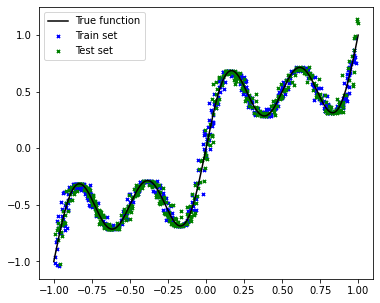

In [5]:
true_x = np.linspace(-1.0, 1.0, 1000)
true_y = true_f(true_x, e=0)

X_train, y_train, X_test, y_test = get_data(500, 500)

plt.figure(figsize = (6, 5))
plt.style.use('default')

plt.plot(true_x, true_y, color='black', label='True function')
plt.scatter(X_train, y_train, s=10, marker='x', color='blue', label='Train set')
plt.scatter(X_test, y_test, s=10, marker='x', color='green', label='Test set')

plt.legend()

plt.show()

In [6]:
X_train_tensor = torch.from_numpy(X_train.reshape((-1, 1))).float().to(device)
y_train_tensor = torch.from_numpy(y_train.reshape((-1, 1))).float().to(device)

X_test_tensor = torch.from_numpy(X_test.reshape((-1, 1))).float().to(device)
y_test_tensor = torch.from_numpy(y_test.reshape((-1, 1))).float().to(device)

In [13]:
n_hidden = 5

model_seq =  nn.Sequential(
          nn.Linear(1, n_hidden),
          nn.ReLU(),
          nn.Linear(n_hidden, n_hidden),
          nn.ReLU(),
          nn.Linear(n_hidden, 1)
        ).to(device)

class Reg2L(nn.Module):
    def __init__(self, n_hidden=10, activation=F.tanh):
        super().__init__()
        self.n_hidden = n_hidden
        self.activation = activation
        self.layer1 = nn.Linear(1, n_hidden)
        self.layer2 = nn.Linear(n_hidden, n_hidden)
        self.layer3 = nn.Linear(n_hidden, 2)

    def forward(self, input):
        h1 = self.layer1(input)
        h2 = self.layer2(self.activation(h1))
        h3 = self.layer3(self.activation(h2))
        m = h3[:, 0]
        s = F.softplus(h3[:, 1]) + 1e-6
        return m, s

model_byhand = Reg2L(n_hidden=n_hidden, activation=F.relu)

In [14]:
num_epoches = 500

optimizer_byhand = torch.optim.Adam(model_byhand.parameters())

for ep in tqdm(range(num_epoches)):
    optimizer_byhand.zero_grad()

    mu, sigma = model_byhand(X_train_tensor)
    #sigma = 1.0
    loss = - torch.distributions.Normal(mu, sigma).log_prob(y_train_tensor).sum()
    loss.backward()
    optimizer_byhand.step()

    if (ep + 1) % 50 == 0:
        with torch.no_grad():
            y_pred, _ = model_byhand(X_test_tensor)
            mse = nn.functional.mse_loss(y_pred, y_test_tensor).to(torch.float32).cpu().mean().numpy()

        print(f"Epoch {ep} MSE {mse}")

  9%|▉         | 47/500 [00:01<00:11, 37.94it/s]<ipython-input-14-a24c1505d869>:17: UserWarning: Using a target size (torch.Size([500, 1])) that is different to the input size (torch.Size([500])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = nn.functional.mse_loss(y_pred, y_test_tensor).to(torch.float32).cpu().mean().numpy()
100%|██████████| 500/500 [00:11<00:00, 43.69it/s]


Epoch 49 MSE 0.292662113904953
Epoch 99 MSE 0.2883497476577759
Epoch 149 MSE 0.29085344076156616
Epoch 199 MSE 0.29076963663101196
Epoch 249 MSE 0.29080307483673096
Epoch 299 MSE 0.2908223867416382
Epoch 349 MSE 0.290836364030838
Epoch 399 MSE 0.2908458113670349
Epoch 449 MSE 0.2908494472503662
Epoch 499 MSE 0.2908482551574707


In [15]:
optimizer_seq = torch.optim.Adam(model_seq.parameters())

for ep in tqdm(range(num_epoches)):
    optimizer_seq.zero_grad()

    mu = model_seq(X_train_tensor)
    loss = - torch.distributions.Normal(mu, 1.0).log_prob(y_train_tensor).sum()
    loss.backward()
    optimizer_seq.step()

    if (ep + 1) % 50 == 0:
        with torch.no_grad():
            y_pred, _ = model_seq(X_test_tensor)
            mse = nn.functional.mse_loss(y_pred, y_test_tensor).to(torch.float32).cpu().mean().numpy()

        print(f"Epoch {ep} MSE {mse}")

  6%|▌         | 28/500 [00:00<00:04, 104.86it/s]<ipython-input-15-699ba90ab83e>:14: UserWarning: Using a target size (torch.Size([500, 1])) that is different to the input size (torch.Size([500])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = nn.functional.mse_loss(y_pred, y_test_tensor).to(torch.float32).cpu().mean().numpy()
100%|██████████| 500/500 [00:02<00:00, 229.57it/s]


Epoch 49 MSE 0.2908482551574707
Epoch 99 MSE 0.2908482551574707
Epoch 149 MSE 0.2908482551574707
Epoch 199 MSE 0.2908482551574707
Epoch 249 MSE 0.2908482551574707
Epoch 299 MSE 0.2908482551574707
Epoch 349 MSE 0.2908482551574707
Epoch 399 MSE 0.2908482551574707
Epoch 449 MSE 0.2908482551574707
Epoch 499 MSE 0.2908482551574707


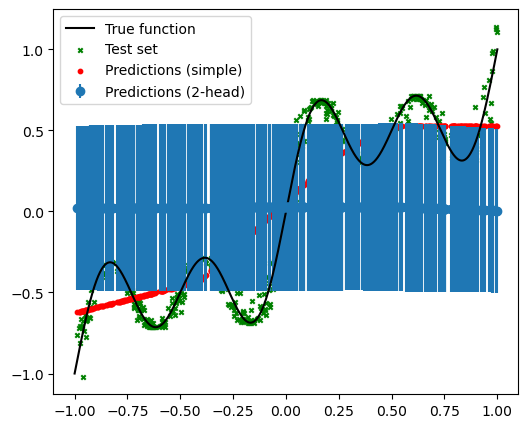

In [17]:
y_pred, sigma_pred = map(lambda x: x.cpu().data.numpy(), model_byhand(X_test_tensor))
y_pred_simple = model_seq(X_test_tensor).cpu().data.numpy()

plt.figure(figsize = (6, 5))
plt.style.use('default')

plt.plot(true_x, true_y, color='black', label='True function')
plt.scatter(X_test, y_test, s=10, marker='x', color='green', label='Test set')

plt.errorbar(X_test, y_pred, yerr=sigma_pred, ls='none', marker='o', label='Predictions (2-head)')

plt.scatter(X_test, y_pred_simple, s=10, marker='o', color='red', label='Predictions (simple)')

plt.legend()

plt.show()